In [10]:
# !pip install gdown
# !pip install tensorflow-gpu
# https://www.curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [4]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /home/jeremy/gitlab/EconomicIndicators/london_bike_sharing.csv
100%|███████████████████████████████████████| 1.03M/1.03M [00:01<00:00, 762kB/s]


In [5]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [6]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month


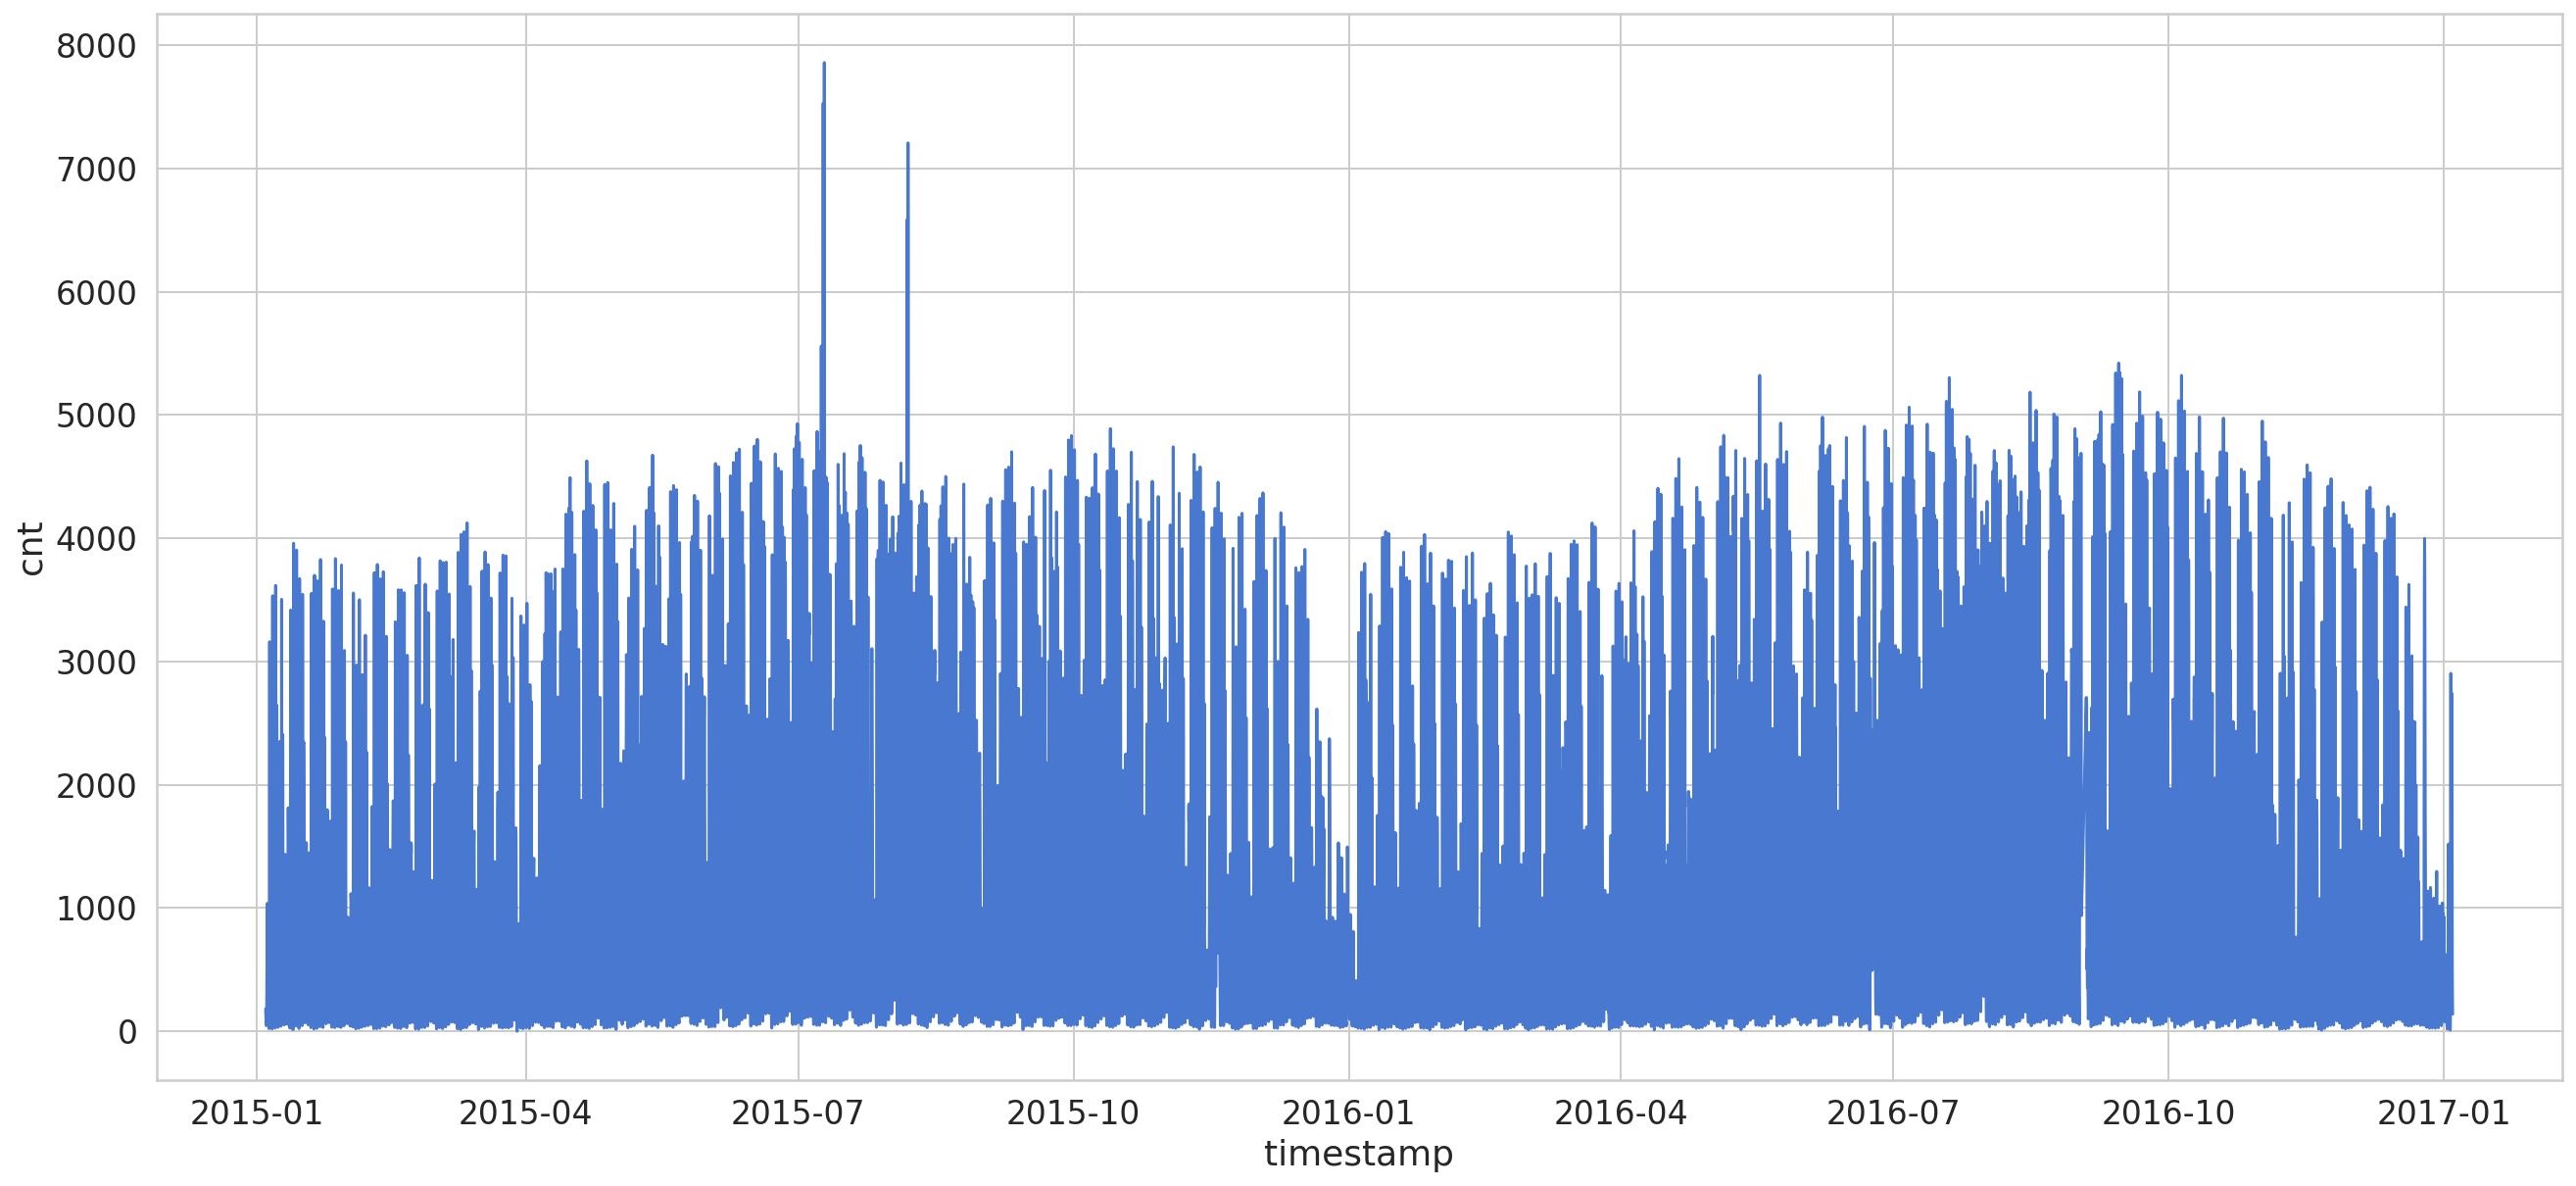

In [7]:
sns.lineplot(x=df.index, y="cnt", data=df);

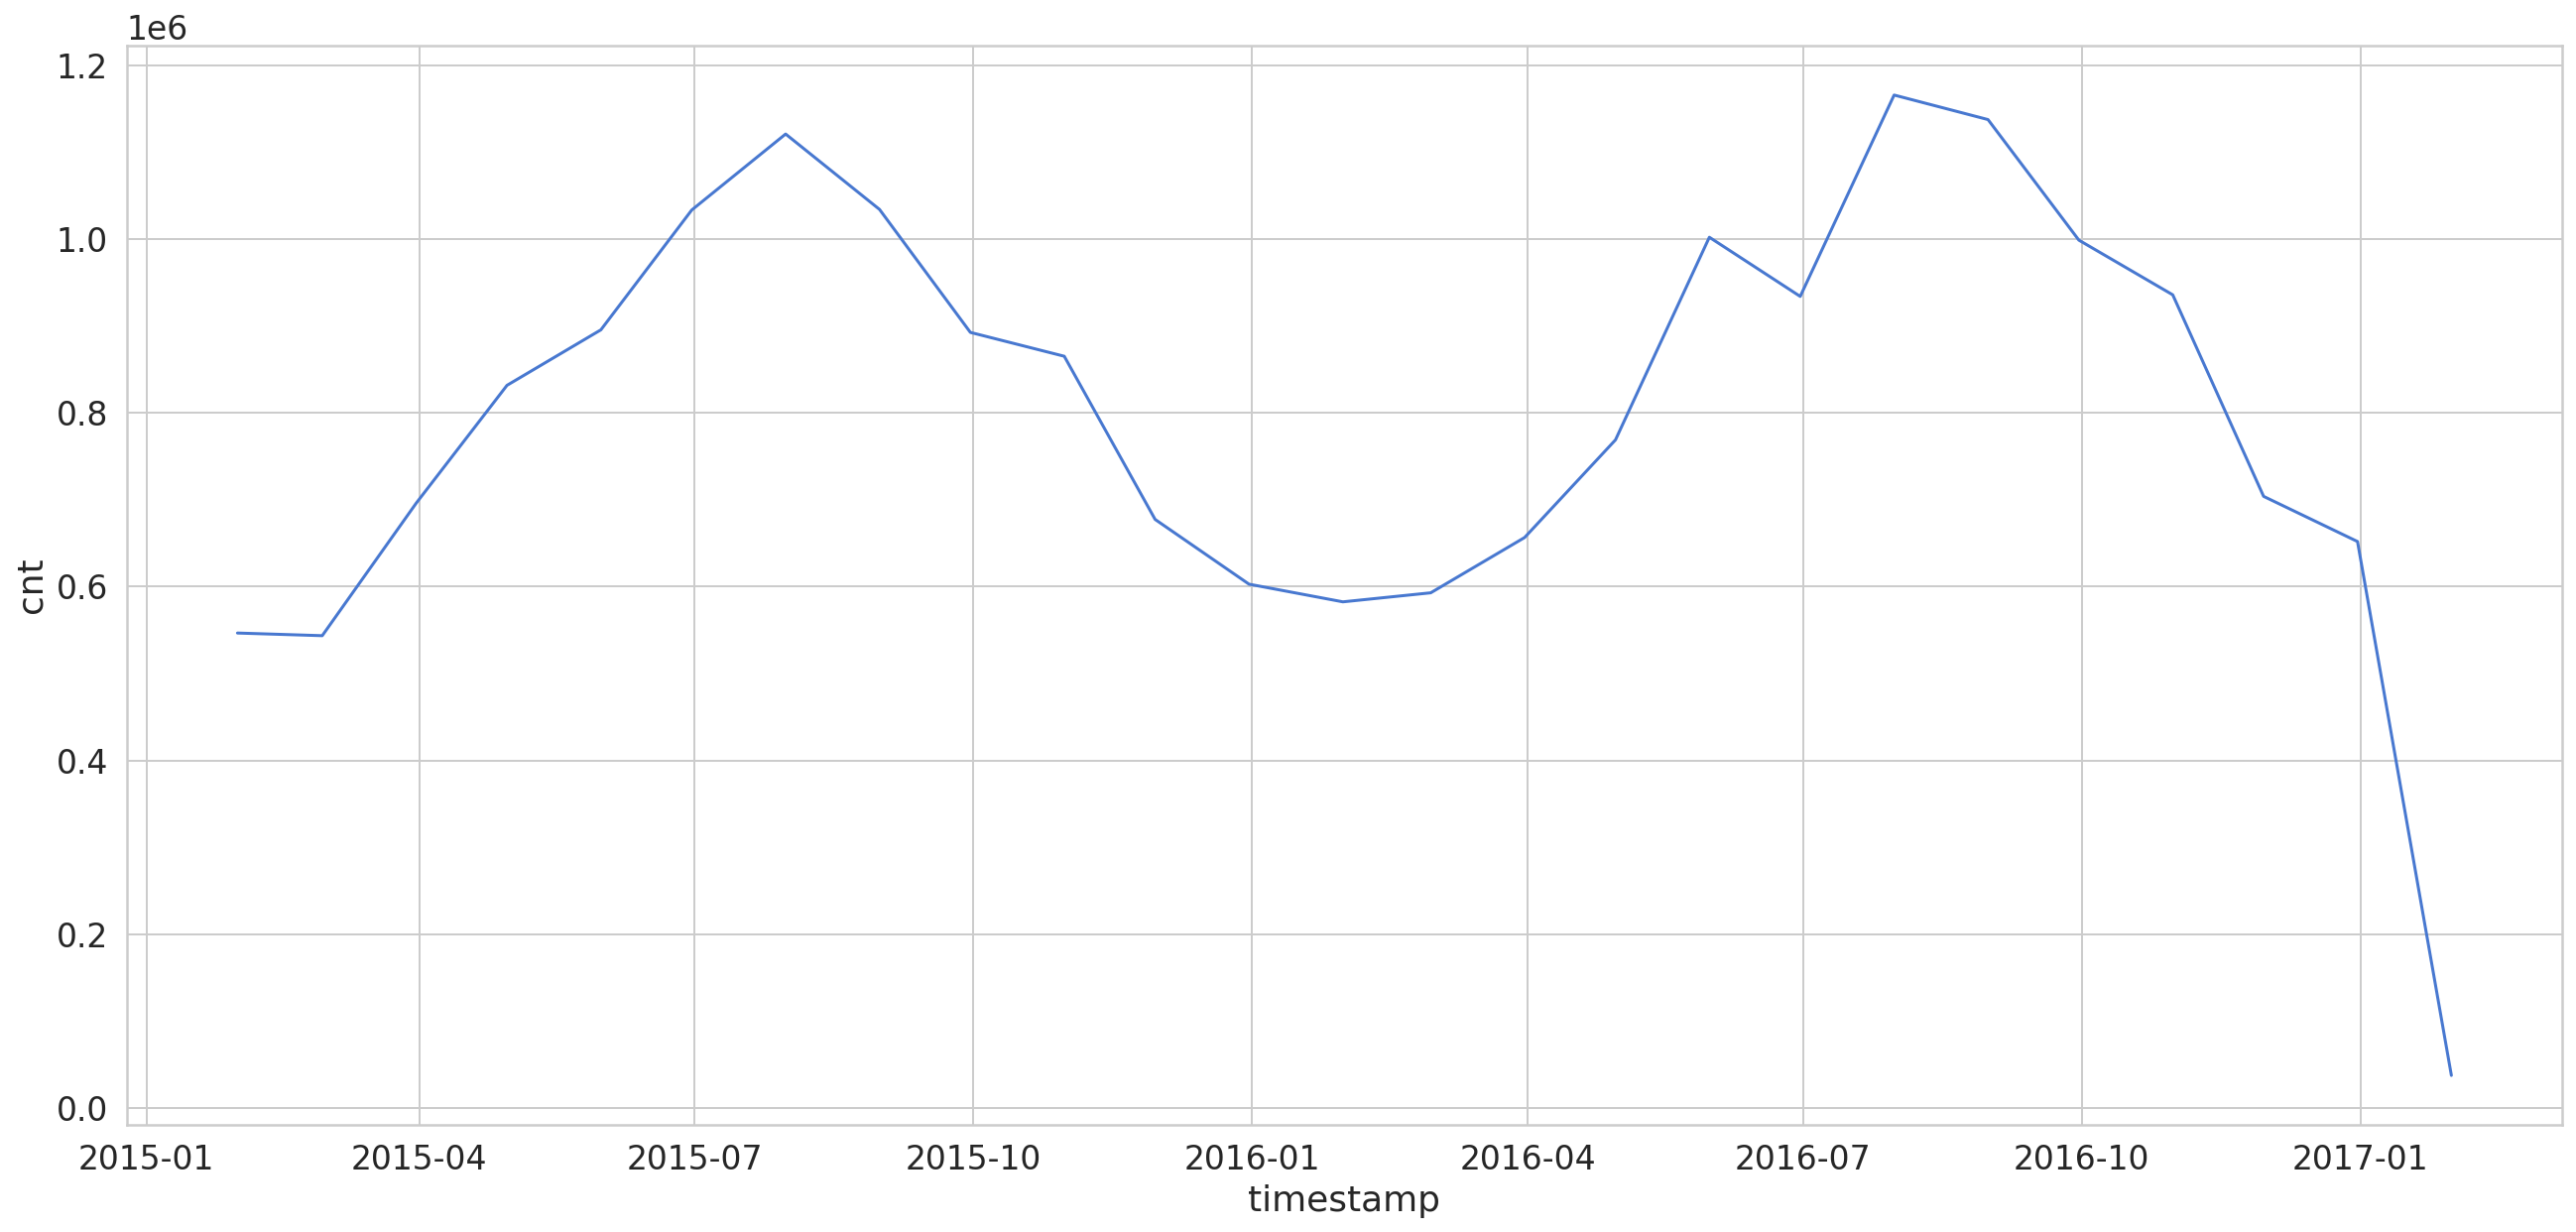

In [8]:
df_by_month = df.resample('M').sum()


sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

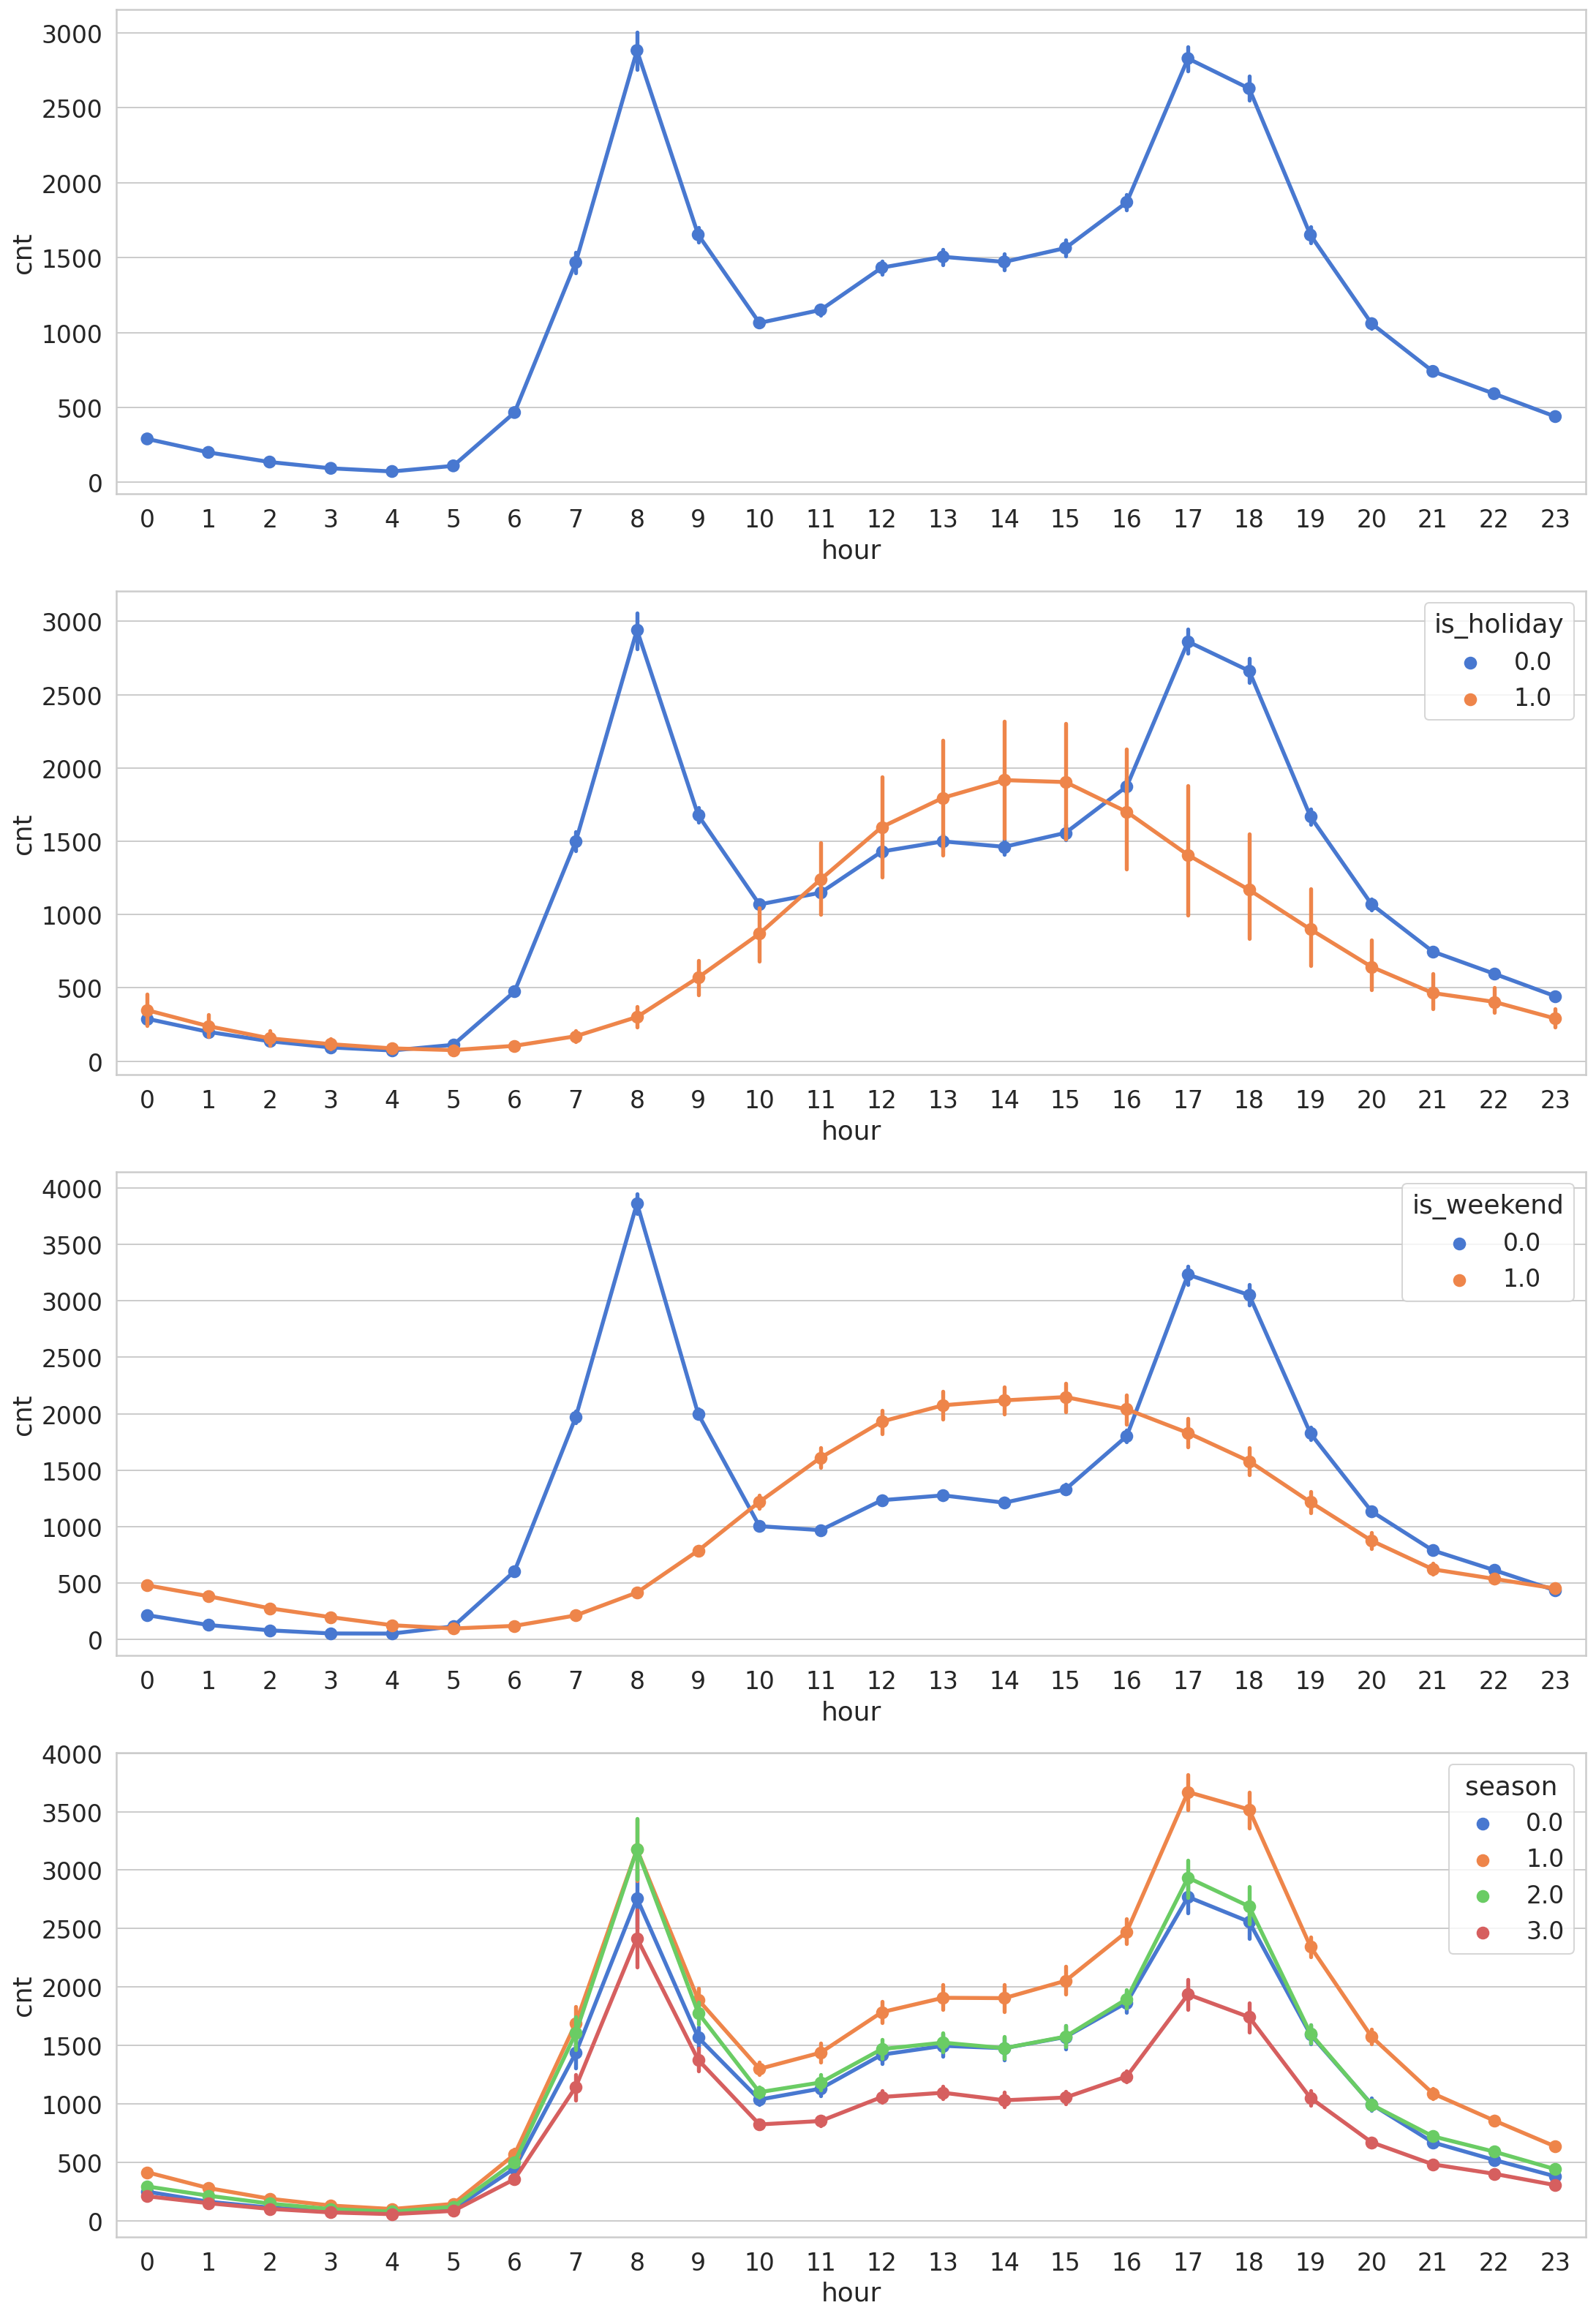

In [9]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

In [11]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [13]:
import warnings
warnings.filterwarnings('ignore')


In [14]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)



(15662, 10, 13) (15662,)


In [17]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 4s 10ms/step - loss: 0.3270 - val_loss: 0.1255
Epoch 2/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0818 - val_loss: 0.0661
Epoch 3/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0512 - val_loss: 0.0552
Epoch 4/30
441/441 [==============================] - 3s 8ms/step - loss: 0.0389 - val_loss: 0.0356
Epoch 5/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0306 - val_loss: 0.0310
Epoch 6/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0276 - val_loss: 0.0311
Epoch 7/30
441/441 [==============================] - 5s 11ms/step - loss: 0.0270 - val_loss: 0.0318
Epoch 8/30
441/441 [==============================] - 5s 11ms/step - loss: 0.0238 - val_loss: 0.0314
Epoch 9/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0233 - val_loss: 0.0321
Epoch 10/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0218 - val_loss: 

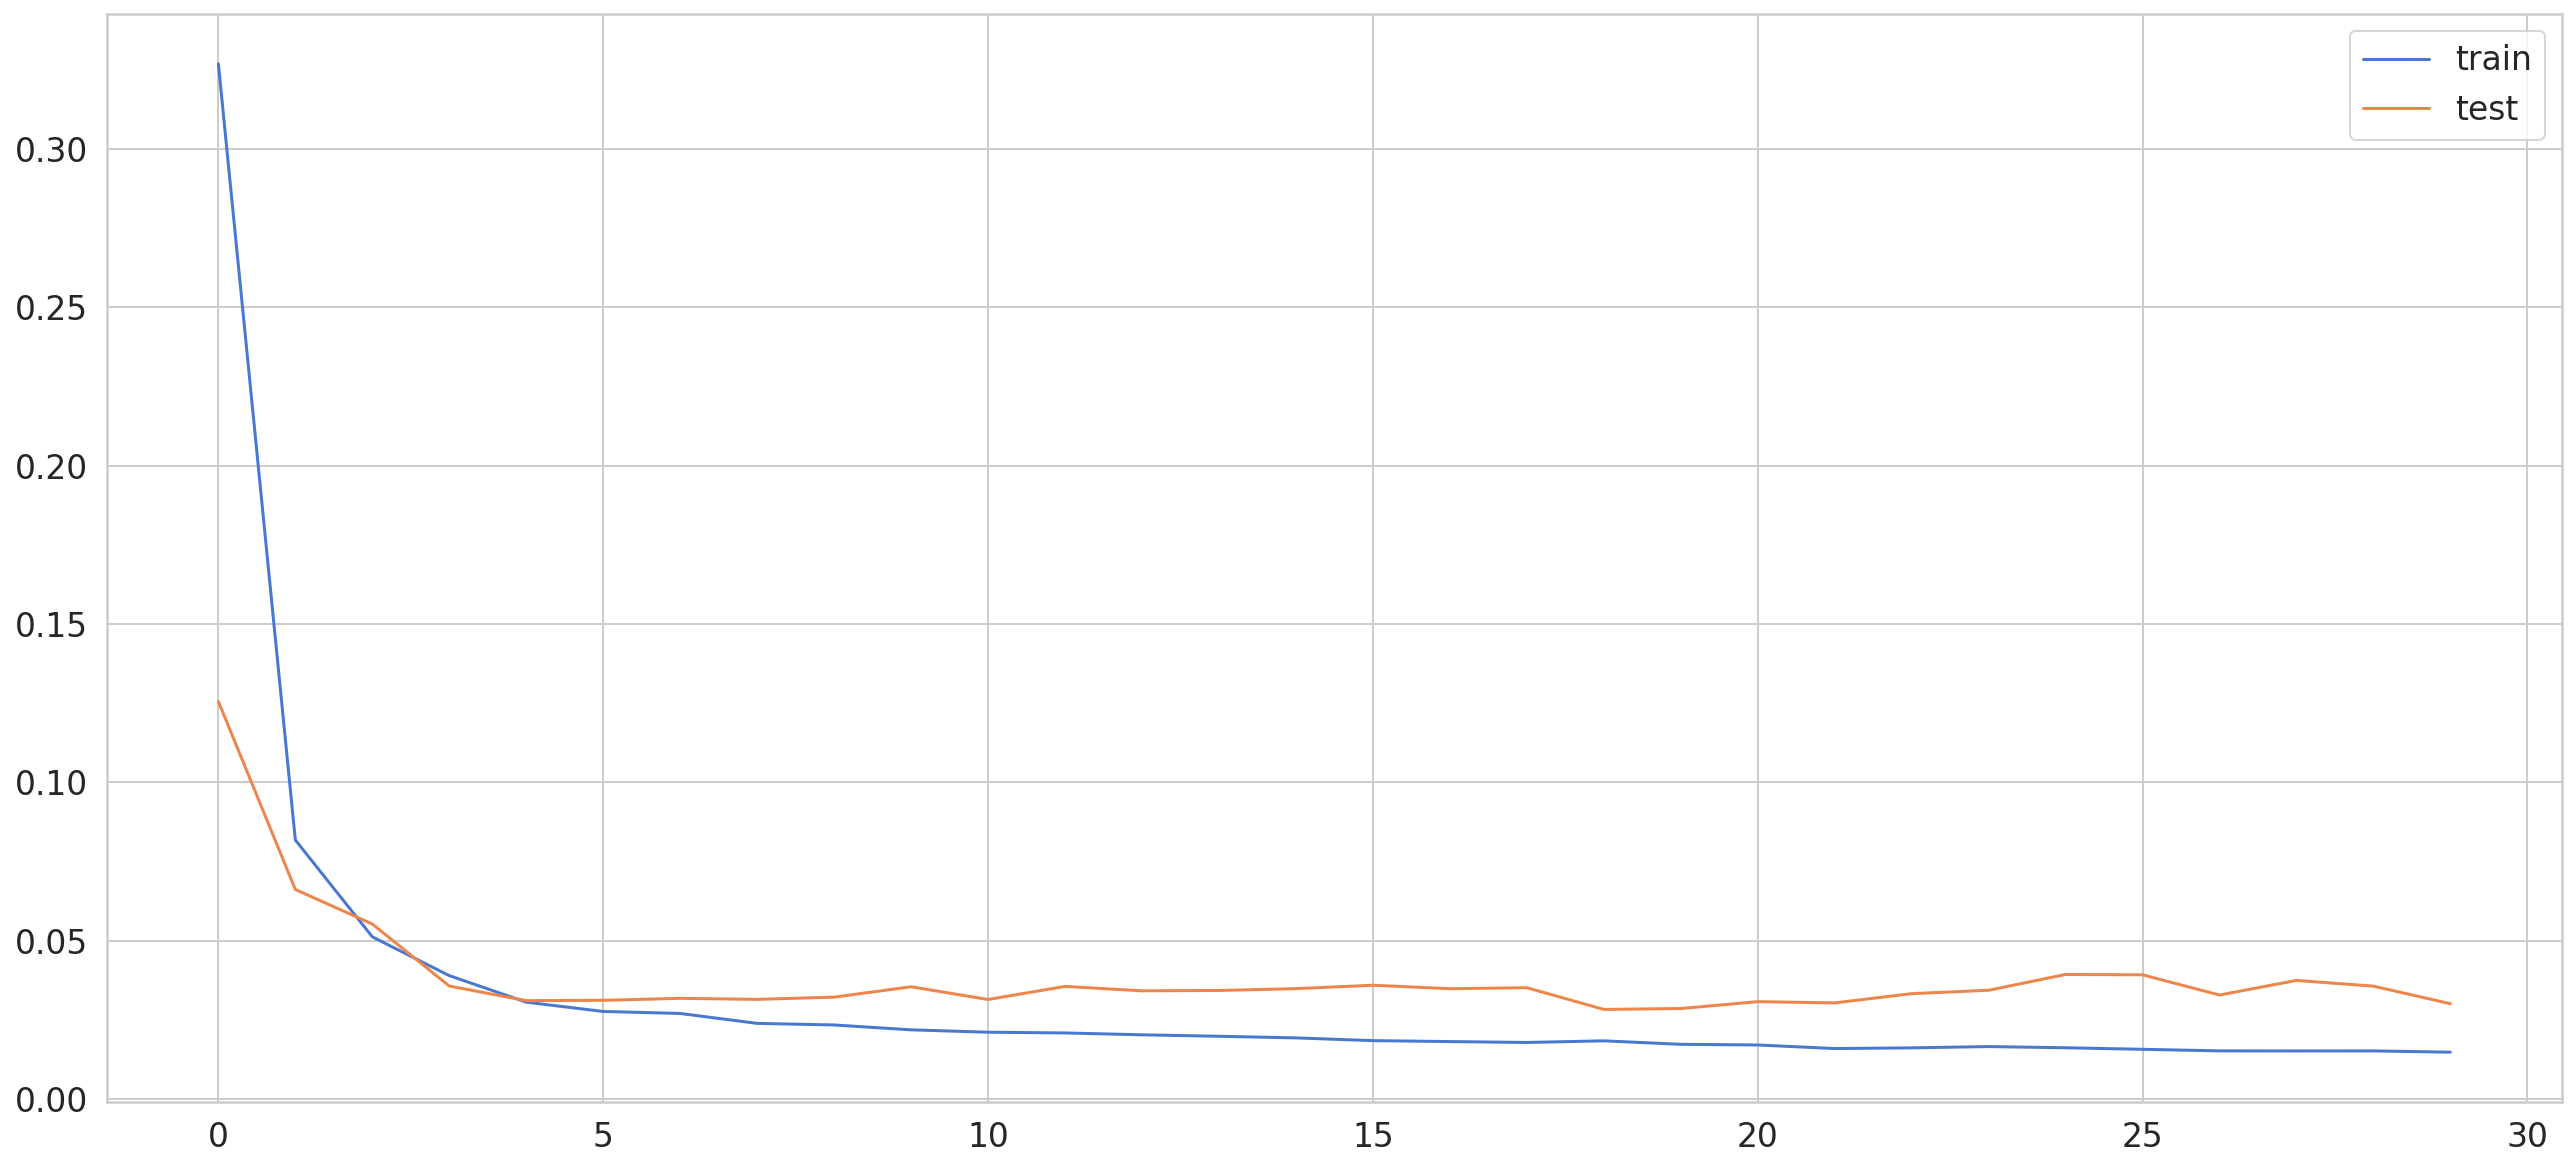

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();